In [1]:
import numpy as np
from utils import read_dataset, drop_useless

In [2]:
# Reading all the data from healthy subject "Finn"
SUBJECT = "Finn"
dataset = read_dataset(SUBJECT,
                       # timestamp="10-12-24",
                       read_ort=False)

# Filling data if joint angles are not calculatable - max fill 1sec 
for nd in dataset:
    nd.fill(1.0)
# cutting data apart and leaving out if joint angle have massiv shifts -> most certainly markers are swapped
dataset = drop_useless(dataset)
# applying moving average filter on emg and joint angle data 
for nd in dataset: 
    nd.moving_average_filter(30, on="emg")
    nd.moving_average_filter(10, on="joints")

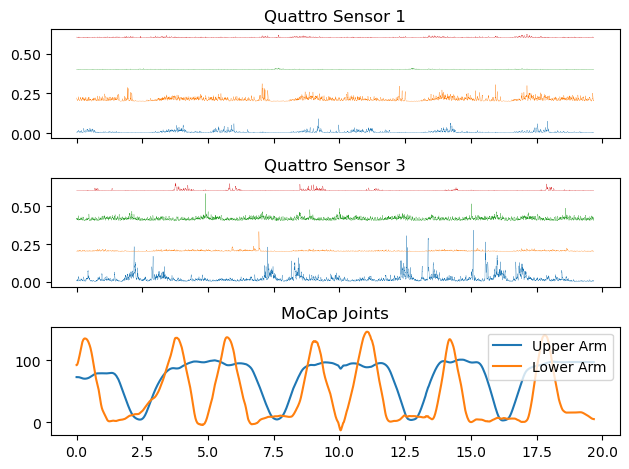

In [3]:
dataset[1].plot(plot_emg=True, plot_mocap_joints=True)

In [4]:
# Make windows --> window size 10 / 100Hz = 100ms equals 222 sample in emg (Sample Rate: 2222Hz) 
# Future offset on mocap is win_size / 2 = 50ms -> predicting 50 ms ahead 
win_size = 10
data = [x.get_data(win_size, win_size, 222, win_size/2) for x in dataset]

In [5]:
joints, marker, marker_pred, emg_data = (np.vstack(x) for x in zip(*data))

In [6]:
# About 6 hours of data 
emg_data.shape[0] * win_size / 100 / 60**2

6.07586111111111

In [7]:
# inputs have ~220k windows each containing 222 Samples and 8 channels; 
# targets is of size ~220k and two joint angles (flexion/extension and supination/pronation)

targets = joints[:, -1, :]
inputs = emg_data
inputs.shape, targets.shape

((218731, 222, 8), (218731, 2))

[ 22908  22157  80412 168321]


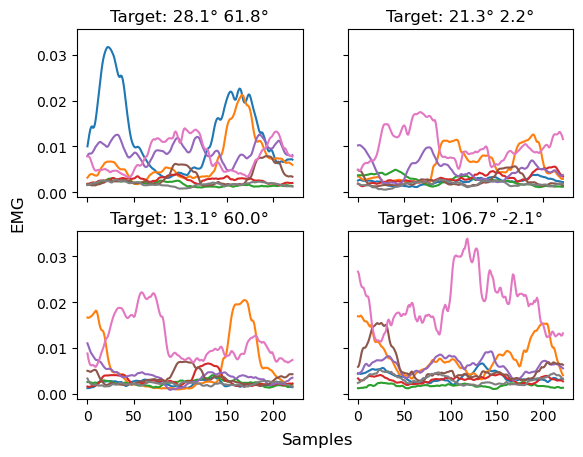

In [8]:
# plot four windows with target as title  
import matplotlib.pyplot as plt 

np.random.seed(100)
indices = np.random.choice(np.arange(inputs.shape[0]), 4, replace=False)
print(indices)
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
fig.supxlabel("Samples")
fig.supylabel("EMG")
for ax, inpt, trgt in zip(axs.flatten(), inputs[indices, :], targets[indices, :]): 
    ax.set_title("Target: %.1f° %.1f°" % (*trgt, ))
    ax.plot(inpt)
plt.show()

In [9]:
# normalize data 

print(inputs.max(), inputs.min())
print(targets.max(), targets.min())

targets = (targets - targets.min()) / (targets.max() - targets.min())
inputs = (inputs - inputs.min()) / (inputs.max() - inputs.min())

1.3130887 2.4274932e-05
157.01103 -28.994228


In [10]:
# shuffle and split the data 
np.random.seed(100)
indices = np.arange(inputs.shape[0])
np.random.shuffle(indices)
inputs = inputs[indices]
targets = targets[indices]
splits = [int(0.7 * inputs.shape[0]), int(0.85 * inputs.shape[0])]
x_train, x_test, x_val = np.split(inputs, splits)
y_train, y_test, y_val = np.split(targets, splits)

In [11]:
# Create model path
import os 
from tensorflow import keras

path = os.path.join("models", SUBJECT, "direct_models", "model001")
if not os.path.exists(path): 
    os.makedirs(path)

2025-01-14 11:31:31.670045: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 11:31:31.678779: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736850691.686591  273525 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736850691.688835  273525 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 11:31:31.697851: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [12]:
# Construct model 

from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Input
from keras.optimizers import Adam

if os.path.exists(os.path.join(path, "best_model.keras")): 
    model = keras.models.load_model(os.path.join(path, "best_model.keras"))
else:    
    model = Sequential()
    model.add(Input((222, 8)))
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(16))
    model.add(Dense(16,  activation="relu"))
    model.add(Dense(8,  activation="relu"))
    model.add(Dense(2, activation="relu"))
    
optimizer = Adam(learning_rate=0.0005)
model.compile(optimizer=optimizer, loss="mse")

I0000 00:00:1736850693.149718  273525 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9543 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:01:00.0, compute capability: 8.6


In [13]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 222, 32)        │         5,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 222, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            18 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,810 (34.41 KB)

 Trainable params: 8,810 (34.41 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# train the model and save best model troughout the training process 

from keras.callbacks import ModelCheckpoint, CSVLogger
import json
from tensorflow.keras.callbacks import Callback

class EpochSaver(Callback):
    def __init__(self, filepath):
        self.filepath = filepath

    def on_epoch_end(self, epoch, logs=None):
        with open(self.filepath, "w") as f:
            json.dump({"last_epoch": epoch + 1}, f)


checkpoint = ModelCheckpoint(os.path.join(path, "best_model.keras"), monitor="val_loss", save_best_only=True, mode="min")
epochs_callback = EpochSaver(os.path.join(path, "last_epoch"))
csv_logger = CSVLogger(os.path.join(path, "model_history_log.csv"), append=True)

initial_epoch = 0
if os.path.exists(os.path.join(path, "last_epoch")):
    with open(os.path.join(path, "last_epoch")) as f: 
        initial_epoch = json.load(f)["last_epoch"]

epochs = 1200
if initial_epoch < epochs:
    history = model.fit(x_train, 
                        y_train, 
                        batch_size=32, 
                        epochs=epochs, 
                        validation_data=[x_val, y_val], 
                        callbacks=[checkpoint, epochs_callback, csv_logger], 
                        initial_epoch=initial_epoch)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.show()

In [15]:
# calculcate R^2 for both joints 
from sklearn.metrics import r2_score

model = keras.models.load_model(os.path.join(path, "best_model.keras"))
prediction = model.predict(x_test)
r2_score(y_test[:, 0], prediction[:, 0]), r2_score(y_test[:, 1], prediction[:, 1])

   6/1026 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step  

I0000 00:00:1736850697.142033  273632 cuda_dnn.cc:529] Loaded cuDNN version 90300


1026/1026 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step  


(0.8119560480117798, 0.6092621088027954)

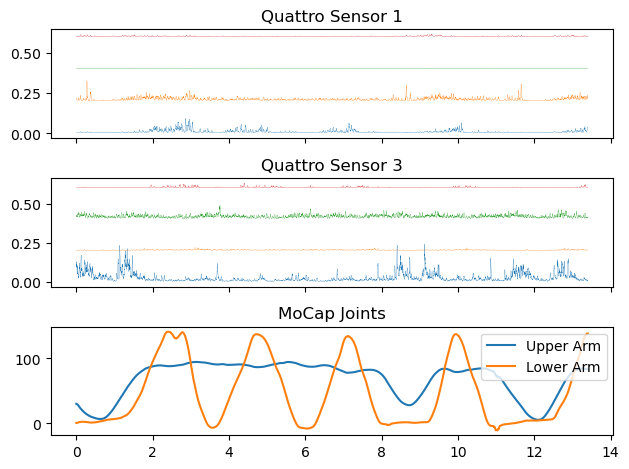

In [16]:
# Take a data bundle (140sec ~ 2 min) and predict it with the model 
dataset[0].plot(plot_emg=True, plot_mocap_joints=True)

In [17]:
# amount of windows in databundle
n_win = dataset[0].mocap_joints.shape[0] * win_size // 100 - 1

In [18]:
# reverse shuffle 
_, idx_back = np.unique(indices, return_index=True)
idx_back = idx_back[:n_win]
pred = model.predict(inputs[idx_back])

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


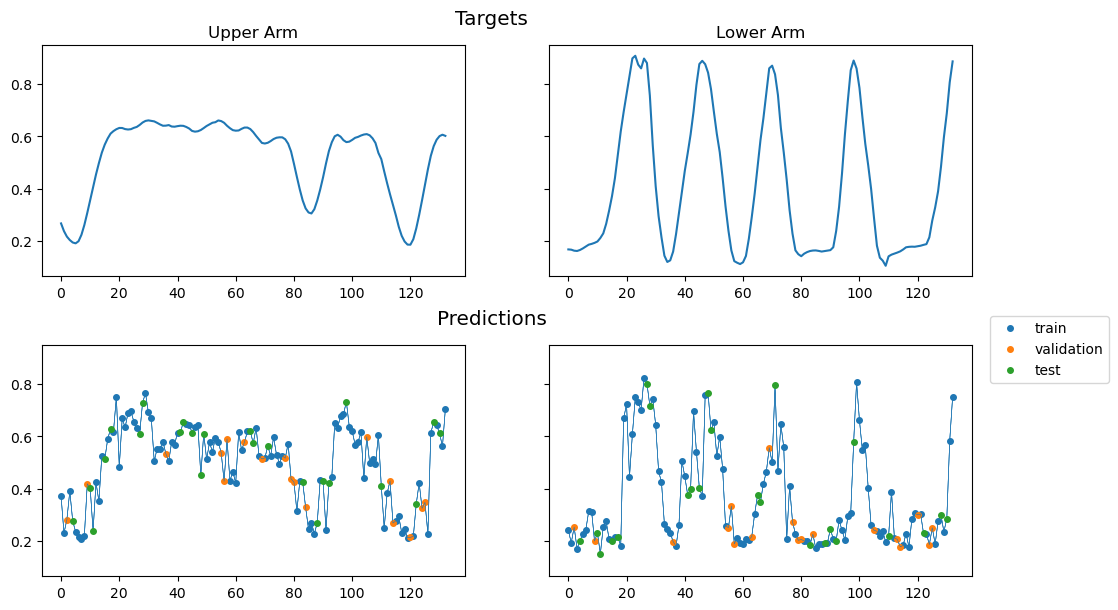

In [19]:
# plot everyting: Upper plots show target (joints) lower plot show predictions based on train, validation or test data 
fig = plt.figure(figsize=(12, 6))
subfigs = fig.subfigures(2, 1)
subfigs[0].suptitle("Targets", fontsize="x-large", y=1.0)
subfigs[1].suptitle("Predictions", fontsize="x-large", y=1.0)
ax_up = subfigs[0].subplots(1, 2, sharey=True)
ax_up[0].set_title("Upper Arm")
ax_up[1].set_title("Lower Arm")
ax_up[0].plot(targets[idx_back, 0])
ax_up[1].plot(targets[idx_back, 1])

ax_low = subfigs[1].subplots(1, 2, sharey=True, sharex=True)
ax_low[0].sharex(ax_up[0])
ax_low[0].sharey(ax_up[0])
masks = (idx_back < splits[0], (idx_back > splits[0]) & (idx_back < splits[1]), idx_back > splits[1])
for mask, label in zip(masks, ("train", "validation", "test")): 
    ax_low[0].plot(pred[:, 0], lw=0.4, c="#1f77b4")
    ax_low[0].plot(np.where(mask)[0], pred[mask, 0], marker="o", linestyle="None", markersize=4, label=label)
    ax_low[1].plot(pred[:, 1], lw=0.4, c="#1f77b4")
    ax_low[1].plot(np.where(mask)[0], pred[mask, 1], marker="o", linestyle="None", markersize=4)
subfigs[1].legend(loc="upper right", bbox_to_anchor=(1.02, 1)) 
plt.show()